<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/011_example_%E7%A5%9E%E7%BB%8F%E9%A3%8E%E6%A0%BC%E8%BD%AC%E7%A7%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TensorFlow2教程-风格转移
神经风格转移是一种优化技术，用于拍摄两个图像 - 内容图像和风格参考图像（如着名画家的作品） - 并将它们混合在一起，使输出图像看起来像内容图像，但“画”在风格参考图像的风格。

这是通过优化输出图像以匹配内容图像的内容统计和样式参考图像的样式统计来实现的。使用卷积网络从图像中提取这些统计数据。

In [1]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

下载图像并选择样式图像和内容图像：

In [2]:
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [5]:
print(content_path)

/root/.keras/datasets/turtle.jpg


In [13]:
img_1 = tf.io.read_file(content_path)

In [17]:
img_1 = tf.image.decode_image(img_1,channels=3)

In [18]:
img_1

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,  98, 123],
        [  0,  98, 123],
        [  0,  99, 124],
        ...,
        [  1, 105, 132],
        [  1, 105, 132],
        [  1, 105, 132]],

       [[  0,  98, 123],
        [  0,  99, 124],
        [  0,  99, 124],
        ...,
        [  1, 105, 132],
        [  1, 105, 132],
        [  1, 105, 132]],

       [[  0,  99, 124],
        [  0,  99, 124],
        [  0, 100, 125],
        ...,
        [  1, 105, 132],
        [  1, 105, 132],
        [  1, 105, 132]],

       ...,

       [[221, 189, 204],
        [247, 219, 205],
        [242, 224, 152],
        ...,
        [127, 127, 101],
        [126, 126, 100],
        [126, 126, 100]],

       [[240, 206, 220],
        [240, 210, 199],
        [242, 222, 163],
        ...,
        [124, 124, 100],
        [118, 120,  96],
        [116, 118,  94]],

       [[255, 226, 237],
        [233, 203, 193],
        [236, 215, 162],
        ...,
        [138, 138, 11

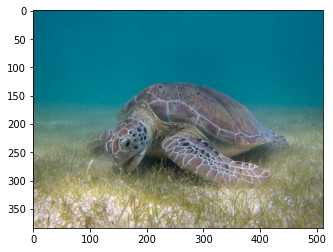

In [19]:
plt.imshow(img_1)

In [20]:
img_1 = tf.image.convert_image_dtype(img_1,tf.float32)
img_1 #使用tf.image.convert_image_dtype方法将一个uint类型的tensor转换为float类型时，该方法会自动对数据进行归一化处理，将数据缩放到0-1范围内，

<tf.Tensor: shape=(384, 512, 3), dtype=float32, numpy=
array([[[0.        , 0.38431376, 0.48235297],
        [0.        , 0.38431376, 0.48235297],
        [0.        , 0.38823533, 0.48627454],
        ...,
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ]],

       [[0.        , 0.38431376, 0.48235297],
        [0.        , 0.38823533, 0.48627454],
        [0.        , 0.38823533, 0.48627454],
        ...,
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ]],

       [[0.        , 0.38823533, 0.48627454],
        [0.        , 0.38823533, 0.48627454],
        [0.        , 0.3921569 , 0.4901961 ],
        ...,
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ],
        [0.00392157, 0.41176474, 0.5176471 ]],

       ...,

       [[0.86666673, 0.7411765 , 0.8000001 ],
        [0.96

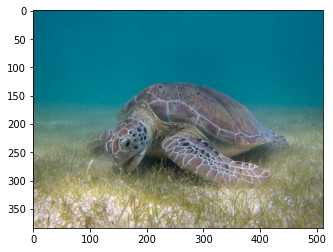

In [24]:
plt.imshow(img_1)

In [21]:
shape_1 = tf.cast(tf.shape(img_1)[:-1],tf.float32)

In [23]:
long_dim_1 = max(shape_1)
long_dim_1

<tf.Tensor: shape=(), dtype=float32, numpy=512.0>

## 可视化输入
定义一个加载图像的函数，并将其最大尺寸限制为512像素。

In [25]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  shape = tf.cast(tf.shape(img)[:-1],tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape*scale,tf.int32)
  img = tf.image.resize(img,new_shape)
  img = img[tf.newaxis,:]
  return img

创建一个简单的函数来显示图像：

In [26]:
def imshow(image,title = None):
  if len(image.shape) >3:
    image = tf.squeeze(image,axis=0)

  plt.imshow(image)
  if title:
    plt.title(title) 

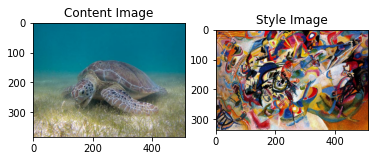

In [27]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1,2,1)
imshow(content_image,'Content Image')
plt.subplot(1,2,2)
imshow(style_image,'Style Image')

## 定义内容和样式表示
使用模型的中间层来获取图像的内容和样式表示。从网络的输入层开始，前几个图层激活表示边缘和纹理等低级特征。当逐步浏览网络时，最后几层代表更高级别的特征 - 对象部分，如轮子或眼睛。在这种情况下，使用的是VGG19网络架构，这是一种预训练的图像分类网络。这些中间层是从图像中定义内容和样式的表示所必需的。对于输入图像，尝试匹配这些中间层的相应样式和内容目标表示。

加载VGG19并在我们的图像上测试运行它以确保正确使用它：

In [28]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [29]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())
predicted_top_5

40960/35363 [==================================] - 0s 0us/step


[[('n01664065', 'loggerhead', 0.74297684),
  ('n01665541', 'leatherback_turtle', 0.113579),
  ('n01986214', 'hermit_crab', 0.05441198),
  ('n01667778', 'terrapin', 0.03923527),
  ('n01667114', 'mud_turtle', 0.012614691)]]

In [30]:
[(class_name, prob) for (number, class_name, prob) in predicted_top_5[0]]

[('loggerhead', 0.74297684),
 ('leatherback_turtle', 0.113579),
 ('hermit_crab', 0.05441198),
 ('terrapin', 0.03923527),
 ('mud_turtle', 0.012614691)]

现在加载VGG19没有分类层的网络结构，并列出图层名称

In [31]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
from keras.utils import plot_model
plot_model(vgg)

从网络中选择中间层以表示图像的样式和内容：

In [36]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']
# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

在高层次上，为了使网络执行图像分类（该网络已被训练过），它必须理解图像。这需要将原始图像作为输入像素并构建内部表示，该原始图像将原始图像像素转换为对图像中存在的特征的复杂理解。

通过访问模型的中间层，可以描述输入图像的内容和样式。

建立模型

tf.keras.applications设计中的网络使您可以使用Keras功能API轻松提取中间层值。

要使用功能API定义模型，请指定输入和输出：

model = Model(inputs, outputs)

以下函数构建一个VGG19模型，该模型返回中间层输出列表：

In [38]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

并创建模型：

In [39]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## 计算风格
图像的内容由中间特征图的值表示。

事实证明，图像的风格可以通过不同特征图上的平均值和相关性来描述。计算包含此信息的Gram矩阵，方法是在每个位置使用特征向量的外积，并在所有位置对该外积进行平均。可以针对特定图层计算此Gram矩阵，如下所示：

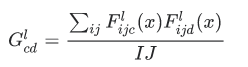

这可以使用以下tf.linalg.einsum函数简洁地实现
[einsum满足你一切需要：深度学习中的爱因斯坦求和约定](https://zhuanlan.zhihu.com/p/44954540)

In [40]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### 提取样式和内容
构建一个返回样式和内容张量的模型。

In [41]:

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

在图像上调用时，此模型返回以下内容的克数矩阵（样式）style_layers和内容content_layers：

In [42]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_results = results['style']
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.03488168
    max:  26723.172
    mean:  780.96204

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95840.28
    mean:  11674.933

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  296185.9
    mean:  7241.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3164084.8
    mean:  104884.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  66307.836
    mean:  650.05994



In [43]:
print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.0783
    mean:  8.983593



## 运行梯度下降
使用此样式和内容提取器，您现在可以实现样式传输算法。通过计算图像输出相对于每个目标的均方误差来做到这一点，然后取这些损失的加权和。

设置样式和内容目标值：

In [44]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

定义一个 tf.Variable以包含要优化的图像。要快速完成此操作，请使用内容图像（tf.Variable必须与内容图像的形状相同）对其进行初始化：

In [45]:
image = tf.Variable(content_image)

In [53]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [46]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

为了优化这一点，使用两个损失的加权组合来获得总损失：

In [47]:
style_weight=1e-2
content_weight=1e4

In [48]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

使用tf.GradientTape更新的图像。

In [54]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

测试

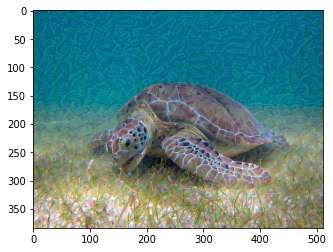

In [55]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

花更多的时间进行优化，就会获得更好的结果

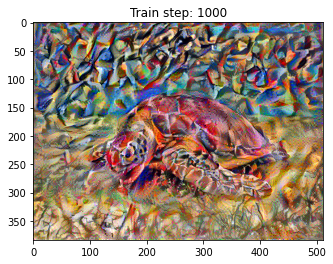

Total time: 65.4


In [56]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

总变异损失

这个基本实现的一个缺点是它会产生大量的高频伪像。 使用图像的高频分量上的显式正则化项来减少这些。 在样式转移中，这通常称为总变异损失：

In [57]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

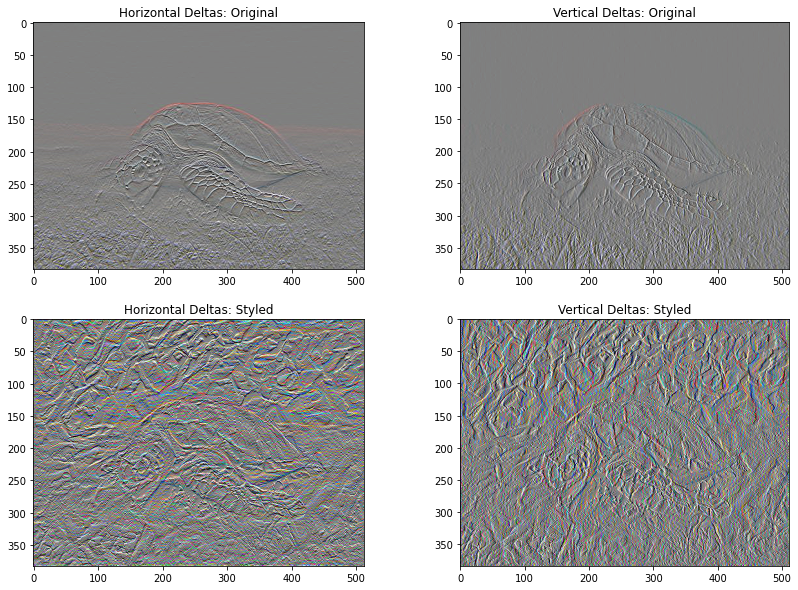

In [58]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

这显示了高频分量如何增加。

而且，该高频分量基本上是边缘检测器。您可以从Sobel边缘检测器获得类似的输出，例如：

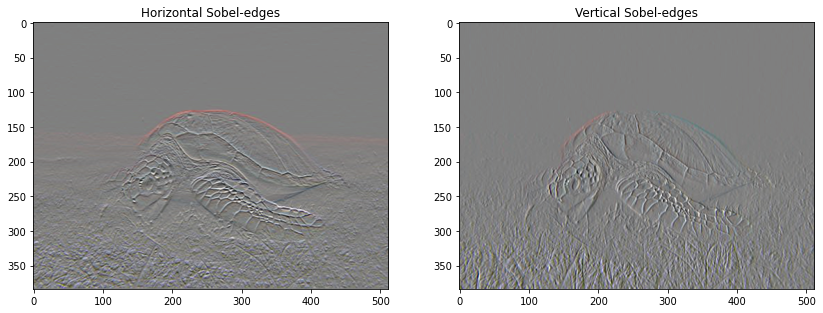

In [59]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

与此相关的正则化损失是值的平方和：

In [60]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

重新运行优化
设定total_variation_loss的权重：

In [61]:
total_variation_weight=1e8

现在将它包含在train_step函数中：

In [62]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

重新初始化变量

In [63]:
image = tf.Variable(content_image)

并运行优化

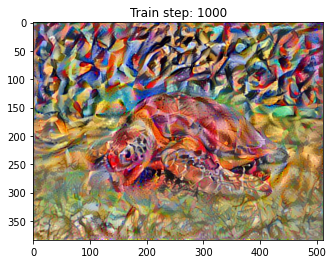

Total time: 66.6


In [64]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))